# BSTS Implementation Tutorial 1: Nowcasting

Hello fellow traveler! I can see by the look on your face that you want to know about how Baysean to implement  can be applied to time series analysis. I too am seeking those riches. The road ahead is dangerous, we should travel together. Will you join me? Great! Lets get going into the woods.

Before we begin, I assume that you know a basic understanding of **time series**: a stochastic process of state variables whose current state depends on its past, with some added random noise. Ahh time series, they are a mysterious and elusive technique used to predict the future. Together we may unravel these secrets. 

Whats that in the thicket? Its a time series of Sea Surface Temperature Off the coast of Gilbralter in the Atlantic Ocean. Lets use BSTS to model this time series, and make forecasts with this data.

Observe how it snakes up and down with the seasons. Bsts is for this seasonality, and models the underlying stationary time series.

In [1]:
library(Boom)
library(zoo)
library(bsts)     # load the bsts package
library(readr)
library('latex2exp')
options( warn = -1 )
options(repr.plot.width=7, repr.plot.height=3)

Warning message:
“package ‘Boom’ was built under R version 3.4.3”Loading required package: MASS

Attaching package: ‘Boom’

The following object is masked from ‘package:stats’:

    rWishart


Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric

Warning message:
“package ‘bsts’ was built under R version 3.4.3”Loading required package: BoomSpikeSlab
Warning message:
“package ‘BoomSpikeSlab’ was built under R version 3.4.3”Loading required package: xts
Warning message:
“package ‘latex2exp’ was built under R version 3.4.4”

This time series is a 12 day aggregate. That makes 30 time indexes per year. 

We kick off bsts by desribing our state. The R code snippit here adds a local linear trend and a seasonal component with the time series object gilT.

These three lines of code are setting up the model as a linear sum.

$$
y_t = \mu_t + \tau_t + \epsilon_t
$$
y sub t is our output variable, where $\mu_t$ is a local linear component, $\tau_t$ is a seasonal component, and $\epsilon_t$ is a white noise process centered around zero with standard deviation $\sigma^2$. 

The model information stated here is stored in the state specification object ss

In [2]:
nseasons = 30 #A 12 day aggregate has 30 samples per period.
ss <- list()
ss <- AddLocalLinearTrend(ss, gilT)
ss <- AddSeasonal(ss, gilT, nseasons=nseasons)

ERROR: Error in stopifnot(is.numeric(y)): object 'gilT' not found


The output variable's posterior distribution is estimated using the bsts() function. As input we use our time series object, state specification, and iteration number. 

In [7]:
model1 <- bsts(gilT,
               state.specification=ss,
               niter = 1000)

=-=-=-=-= Iteration 0 Tue Apr 10 11:30:19 2018 =-=-=-=-=
=-=-=-=-= Iteration 100 Tue Apr 10 11:30:21 2018 =-=-=-=-=
=-=-=-=-= Iteration 200 Tue Apr 10 11:30:22 2018 =-=-=-=-=
=-=-=-=-= Iteration 300 Tue Apr 10 11:30:23 2018 =-=-=-=-=
=-=-=-=-= Iteration 400 Tue Apr 10 11:30:24 2018 =-=-=-=-=
=-=-=-=-= Iteration 500 Tue Apr 10 11:30:26 2018 =-=-=-=-=
=-=-=-=-= Iteration 600 Tue Apr 10 11:30:27 2018 =-=-=-=-=
=-=-=-=-= Iteration 700 Tue Apr 10 11:30:28 2018 =-=-=-=-=
=-=-=-=-= Iteration 800 Tue Apr 10 11:30:29 2018 =-=-=-=-=
=-=-=-=-= Iteration 900 Tue Apr 10 11:30:31 2018 =-=-=-=-=


What just happened? The output model1 is a list with the following keys.

In [8]:
names(model1)

[1] "sigma.obs"                  "sigma.trend.level"         
 [3] "sigma.trend.slope"          "sigma.seasonal.30"         
 [5] "final.state"                "state.contributions"       
 [7] "one.step.prediction.errors" "log.likelihood"            
 [9] "has.regression"             "state.specification"       
[11] "prior"                      "timestamp.info"            
[13] "model.options"              "family"                    
[15] "niter"                      "original.series"

We assume our model converges after 1000 iterations. We check if our assumption is valid by plotting our Expected conditional posterior with the data, shown on this chart. The blue bubbles are data, and the black line is our model. Looks alright to me.

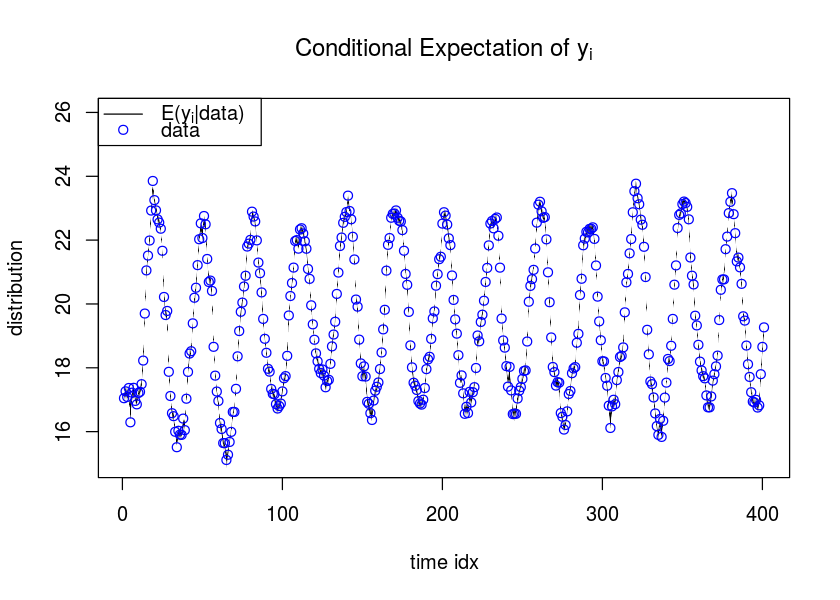

In [9]:
options(repr.plot.width=7, repr.plot.height=5)
plot(model1,
    main=TeX('Conditional Expectation of $y_i$'),
    xlab='time idx',
    ylab='distribution', 
    ylim=c(15, 26))
par(xpd=TRUE)
legend("topleft", legend=c(TeX('$E(y_i|data)$'), "data"),
col=c("black", "blue"), lty=c(1,NA), pch=c(NA, 1), cex=1)

Adding a 'components' tag to the plot displays trend and seasonal data. We can see that our bsts model captures the seasonality and trend fairly well.

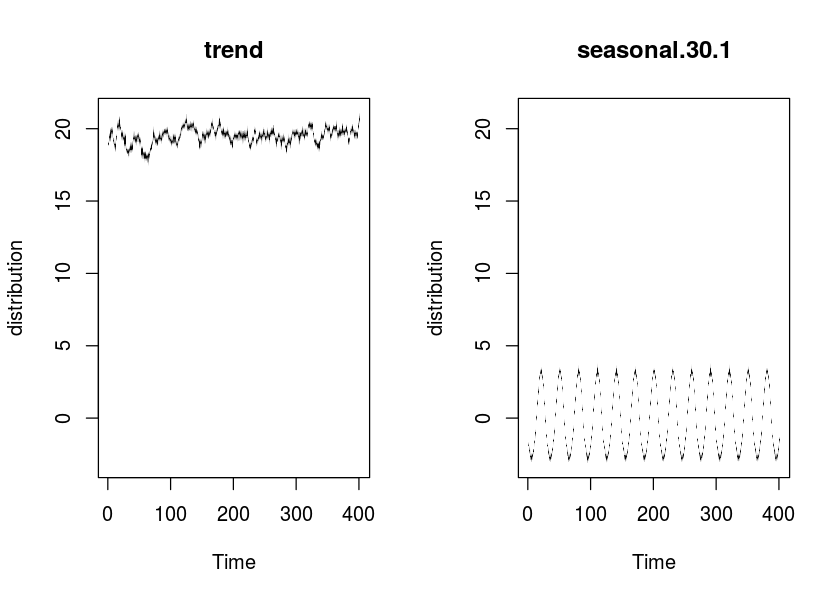

In [10]:
plot(model1, "components")

From here we can make forcasts. The chart here predicts 12 time steps in the future (144 days). The predictive posterior is in black in white. See how the green dotted lines spread apart as we predict further in the future? This typical for non-stationary time series such as ours. I Wonder if there is anything we can do to make this interval more narrow. Can we improve the model's predicitive precision? 

In our next video, we will look into refining our model by including linear regression terms. I will meet you there.

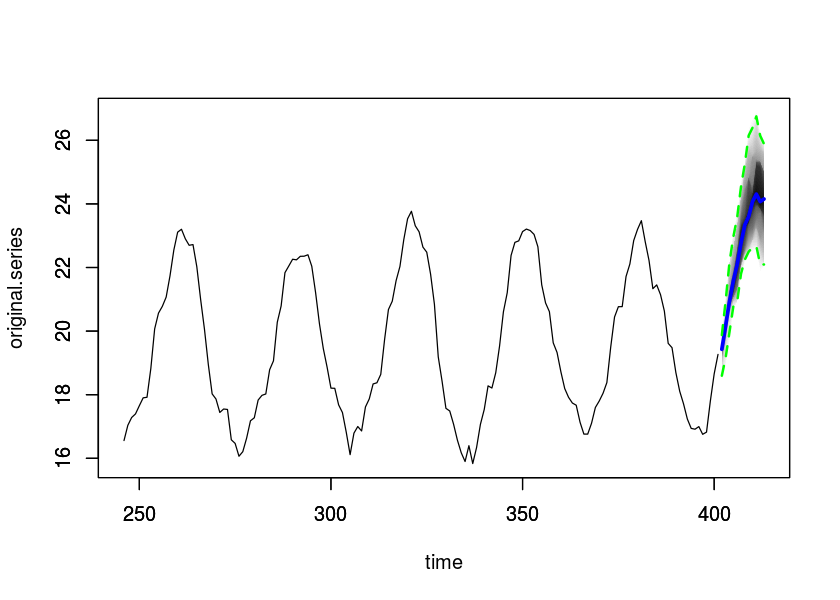

In [11]:
pred1 <- predict(model1, horizon = 12)
plot(pred1, plot.original = 156)

In [12]:
pred1

$mean
 [1] 19.41802 20.08990 21.04942 21.62672 22.10839 22.97011 23.51413 23.98392
 [9] 24.18147 24.53910 24.29096 24.09388

$median
 [1] 19.42827 20.17365 20.94275 21.58158 22.09406 22.76895 23.33895 23.60184
 [9] 24.07202 24.30776 24.07184 24.15395

$interval
          [,1]     [,2]     [,3]     [,4]     [,5]     [,6]     [,7]     [,8]
2.5%  18.59706 19.17422 19.97477 20.77706 20.92294 21.80181 22.24933 22.49742
97.5% 19.87516 20.95417 22.16982 22.96354 23.57519 24.54034 25.25780 26.14960
          [,9]    [,10]    [,11]    [,12]
2.5%  22.62940 22.67412 22.09374 22.09482
97.5% 26.39466 26.75288 26.14618 25.88673

$distribution
          [,1]     [,2]     [,3]     [,4]     [,5]     [,6]     [,7]     [,8]
 [1,] 18.45025 18.93948 19.67066 20.68755 21.33632 22.02652 22.16894 22.67043
 [2,] 19.89284 20.33771 21.65835 22.63206 23.33550 24.25044 25.18309 26.35930
 [3,] 19.84570 20.65212 22.15625 23.16243 23.71466 24.71428 24.98439 25.62775
 [4,] 19.08513 19.74024 20.89776 21.73147 22.54516 

### Your quest, should you choose to accept...

What a method! But how does it work? Glory and reward await those who are brave enough to navigate the trials and tribulations involved in learning bsts. Come stalwart adventurer! let us explore this dungeon of mysterious treasures. In the following tutorials, we will battle untold horrors and demons together, who guard the secrects of bsts. With this power we will be able to

* Modeling non-gaussian noise

* Apply Spike and slab priors (a flatish prior with a large spike at zero. This prior is saying that the regression components are most likely zero, but if not are relatively flat.

* Apply several type of Monte Carlo Markov Chains

* Forcast long term trends

Some theory reading is available here [here](http://people.ischool.berkeley.edu/~hal/Papers/2013/pred-present-with-bsts.pdf)

Another tutorial by Steven L. Scott, the Author of BSTS is [here](http://www.unofficialgoogledatascience.com/2017/07/fitting-bayesian-structural-time-series.html)

Code used to create this notebook is located [here](https://github.com/asbates/bayes-time-series)

[bsts documentation](https://cran.r-project.org/web/packages/bsts/bsts.pdf)

## Linear regression with spike and slab priors

In [3]:
data(iclaims)     # bring the initial.claims data into scope
names(initial.claims)
ss <- AddLocalLinearTrend(list(), initial.claims$iclaimsNSA)
ss <- AddSeasonal(ss, initial.claims$iclaimsNSA, nseasons = 52)

[1] "iclaimsNSA"                 "michigan.unemployment"     
 [3] "idaho.unemployment"         "pennsylvania.unemployment" 
 [5] "unemployment.filing"        "new.jersey.unemployment"   
 [7] "department.of.unemployment" "illinois.unemployment"     
 [9] "rhode.island.unemployment"  "unemployment.office"       
[11] "filing.unemployment"

In [21]:
#iclaimsNSA is the output y, and the rest is xi

model2 <- bsts(iclaimsNSA ~ .,
               state.specification = ss,
               niter = 1000,
               data = initial.claims)

=-=-=-=-= Iteration 0 Tue Apr 10 11:39:04 2018 =-=-=-=-=
=-=-=-=-= Iteration 100 Tue Apr 10 11:39:07 2018 =-=-=-=-=
=-=-=-=-= Iteration 200 Tue Apr 10 11:39:10 2018 =-=-=-=-=
=-=-=-=-= Iteration 300 Tue Apr 10 11:39:13 2018 =-=-=-=-=
=-=-=-=-= Iteration 400 Tue Apr 10 11:39:15 2018 =-=-=-=-=
=-=-=-=-= Iteration 500 Tue Apr 10 11:39:18 2018 =-=-=-=-=
=-=-=-=-= Iteration 600 Tue Apr 10 11:39:21 2018 =-=-=-=-=
=-=-=-=-= Iteration 700 Tue Apr 10 11:39:24 2018 =-=-=-=-=
=-=-=-=-= Iteration 800 Tue Apr 10 11:39:27 2018 =-=-=-=-=
=-=-=-=-= Iteration 900 Tue Apr 10 11:39:30 2018 =-=-=-=-=


In [19]:
initial.claims

           iclaimsNSA michigan.unemployment idaho.unemployment
2004-01-04      2.536                 1.488             -0.561
2004-01-11      0.882                 1.100             -0.992
2004-01-18     -0.077                 1.155             -1.212
2004-01-25      0.135                 0.530             -1.034
2004-02-01      0.373                 0.698             -1.195
2004-02-08     -0.437                 0.441             -1.386
2004-02-15     -0.556                 0.405             -0.844
2004-02-22     -0.432                -0.016             -1.001
2004-02-29     -0.460                 0.271             -1.234
2004-03-07     -0.698                -0.357             -1.269
2004-03-14     -0.765                -0.006             -1.326
2004-03-21     -0.833                -0.647             -2.124
2004-03-28     -0.767                -0.282             -1.615
2004-04-04     -0.356                -0.503             -1.035
2004-04-11     -0.496                -0.998            

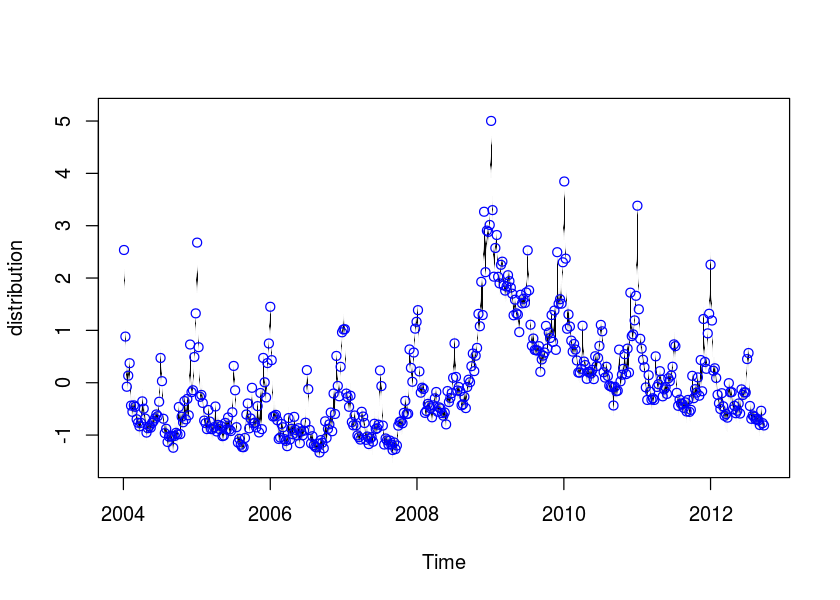

In [22]:
plot(model2)

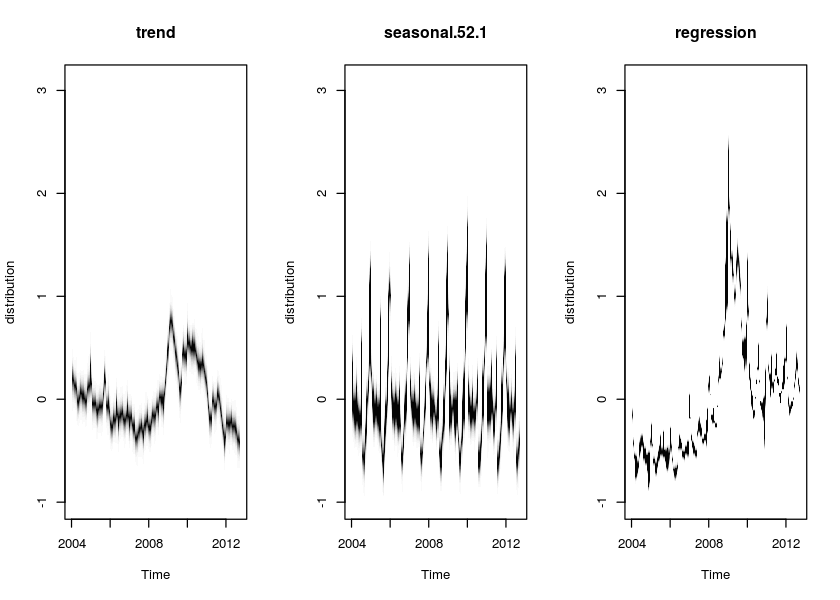

In [23]:
plot(model2, "comp")

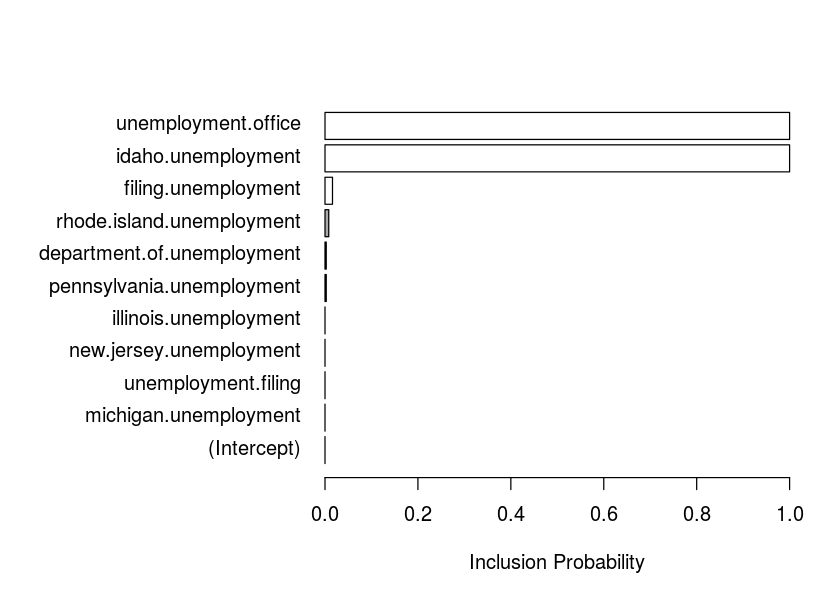

In [24]:
plot(model2, "coef")

In [25]:
 model3 <- bsts(iclaimsNSA ~ .,
               state.specification = ss,
               niter = 1000,
               data = initial.claims,
               expected.model.size = 5)  # Passed to SpikeSlabPrior.

=-=-=-=-= Iteration 0 Tue Apr 10 11:46:10 2018 =-=-=-=-=
=-=-=-=-= Iteration 100 Tue Apr 10 11:46:13 2018 =-=-=-=-=
=-=-=-=-= Iteration 200 Tue Apr 10 11:46:16 2018 =-=-=-=-=
=-=-=-=-= Iteration 300 Tue Apr 10 11:46:18 2018 =-=-=-=-=
=-=-=-=-= Iteration 400 Tue Apr 10 11:46:21 2018 =-=-=-=-=
=-=-=-=-= Iteration 500 Tue Apr 10 11:46:24 2018 =-=-=-=-=
=-=-=-=-= Iteration 600 Tue Apr 10 11:46:27 2018 =-=-=-=-=
=-=-=-=-= Iteration 700 Tue Apr 10 11:46:30 2018 =-=-=-=-=
=-=-=-=-= Iteration 800 Tue Apr 10 11:46:32 2018 =-=-=-=-=
=-=-=-=-= Iteration 900 Tue Apr 10 11:46:35 2018 =-=-=-=-=


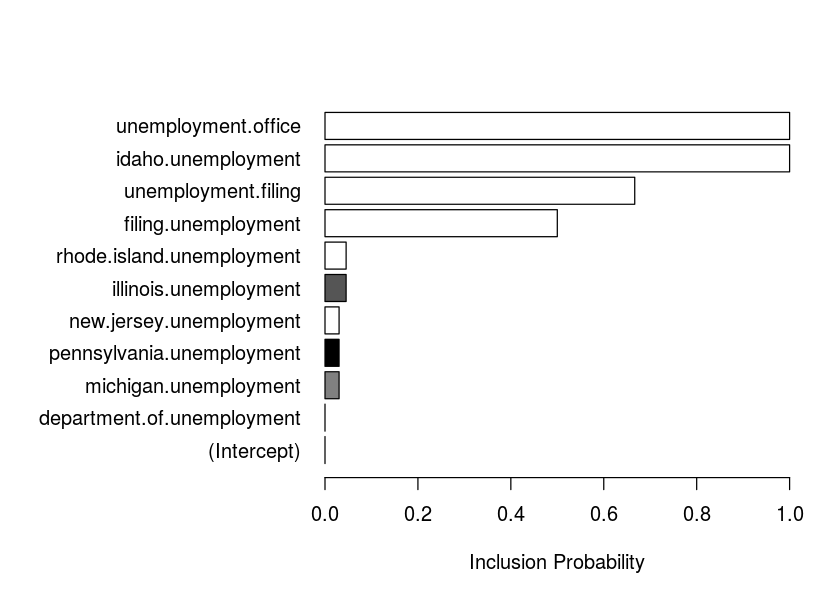

In [26]:
plot(model3, "coef")

In [27]:
model1 <- bsts(initial.claims$iclaimsNSA,
               state.specification = ss,
               niter = 1000)

=-=-=-=-= Iteration 0 Tue Apr 10 11:47:57 2018 =-=-=-=-=
=-=-=-=-= Iteration 100 Tue Apr 10 11:48:00 2018 =-=-=-=-=
=-=-=-=-= Iteration 200 Tue Apr 10 11:48:02 2018 =-=-=-=-=
=-=-=-=-= Iteration 300 Tue Apr 10 11:48:05 2018 =-=-=-=-=
=-=-=-=-= Iteration 400 Tue Apr 10 11:48:08 2018 =-=-=-=-=
=-=-=-=-= Iteration 500 Tue Apr 10 11:48:10 2018 =-=-=-=-=
=-=-=-=-= Iteration 600 Tue Apr 10 11:48:13 2018 =-=-=-=-=
=-=-=-=-= Iteration 700 Tue Apr 10 11:48:16 2018 =-=-=-=-=
=-=-=-=-= Iteration 800 Tue Apr 10 11:48:19 2018 =-=-=-=-=
=-=-=-=-= Iteration 900 Tue Apr 10 11:48:21 2018 =-=-=-=-=


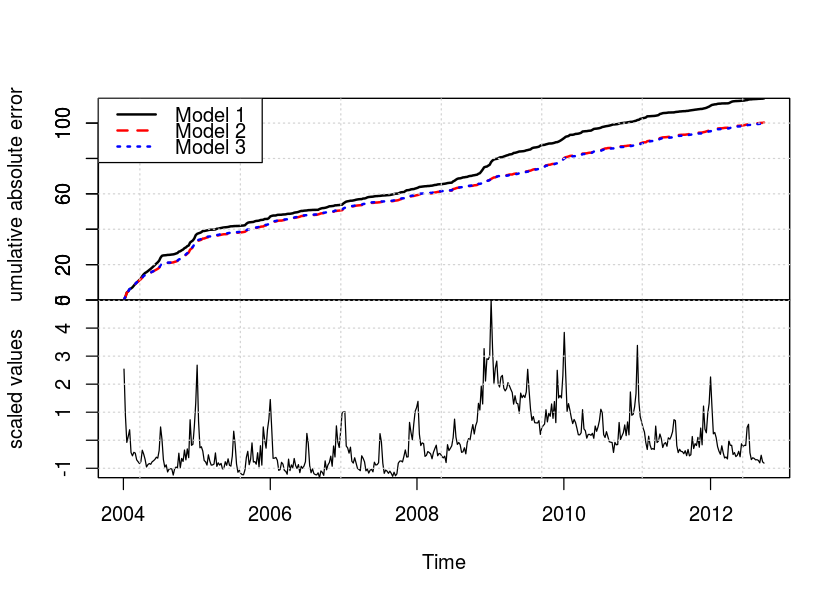

In [28]:
CompareBstsModels(list("Model 1" = model1,
                       "Model 2" = model2,
                       "Model 3" = model3),
                  colors = c("black", "red", "blue"))

## Logistic regression

In [2]:
 ## Because 'y' is 0/1 and the state is on the logit scale the default prior
## assumed by AddLocalLevel won't work here, so we need to explicitly set the
## priors for the variance of the state innovation errors and the initial value
## of the state at time 0.  The 'SdPrior' and 'NormalPrior' functions used to
## define these priors are part of the Boom package.  See R help for
## documentation.  Note the truncated support for the standard deviation of the
## random walk increments in the local level model.
ss <- AddLocalLevel(list(),
                    sigma.prior = SdPrior(sigma.guess = .1,
                                          sample.size = 1,
                                          upper.limit = 1),
                    initial.state.prior = NormalPrior(0, 5))


## Tell bsts that the observation equation should be a logistic regression by
## passing the 'family = "logit"' argument.
ts.model <- bsts(nber ~ ., ss, data = gdp, niter = 20000,family = "logit", expected.model.size = 10)

ERROR: Error in is.data.frame(data): object 'gdp' not found


In [ ]:
gilbralter <- read_csv("data/gilbralter_time_series_all.csv")
gilD <- ts(gilbralter$tempMean, start=c(2004,1,13), end=c(2017, 11, 25), frequency=30)
plot(gilT, main='SST of Gilbralter region',
    xlab='date',
    ylab='Temperature [C]', 
    ylim=c(15, 26))

In [ ]:
/home/tyler/Desktop/STAT676/project/gilbralter/gilbralter_time_series_all.csv
/home/tyler/Desktop/STAT676/project/gilbralter/tempColorChart.png

In [32]:
png(filename = "data/tempColorChart.png")

In [6]:
type(initial.claims)

ERROR: Error in type(initial.claims): could not find function "type"


In [8]:
gilbralter <- read_csv("./data/gilbralter_time_series_all.csv")

ERROR: Error: './data/gilbralter_time_series_all.csv' does not exist in current working directory ('/home/tyler/Desktop/STAT676/bayes-time-series').


In [10]:
cwd()

ERROR: Error in cwd(): could not find function "cwd"
